In [190]:
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2
from tqdm import tqdm
from arguments import ModelParams, PipelineParams, ModelHiddenParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature, render_segmentation
from segment_anything import (SamAutomaticMaskGenerator, SamPredictor,
                              sam_model_registry)
from utils.sh_utils import SH2RGB
import imageio
from utils.segment_utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyper-parameters

In [191]:
import os
FEATURE_DIM = 32

DATA_ROOT = './data/hypernerf/split-cookie'
# the model path, same to the --model_path in the training, after train_scene.py this folder will be created but named randomly
MODEL_PATH = './output/hypernerf/split-cookie'
# 'lego_real_night_radial'
SPIN_SCENE_NAME = 'lego_real_night_radial'
NVOS_SCENE_NAME = 'orchids'
FEATURE_GAUSSIAN_ITERATION = 14000

SAM_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/sam_proj.pt')
NEG_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/neg_proj.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/point_cloud.ply')

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '/data/sxj/SegAnyGAussians/dependencies/sam_ckpt/sam_vit_h_4b8939.pth'

## Data and Model Preparation

Looking for config file in ./output/hypernerf/split-cookie/cfg_args
Config file found: ./output/hypernerf/split-cookie/cfg_args
SAM feature low dim:  32
Loading trained 4DGS model at iteration 14000
Loading trained feature-4DGS model at iteration 14000
load finished


135it [00:00, 62456.55it/s]


format finished


100%|██████████| 135/135 [00:03<00:00, 41.36it/s]


Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [14.73768902 10.22335386 67.65579987] [-24.60894775 -40.18284988   9.55506134]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 14.7377,  10.2234,  67.6558],
        [-24.6089, -40.1828,   9.5551]])
Loading pretrained feature-4dgs model
loading model from exists./output/hypernerf/split-cookie/point_cloud/iteration_14000


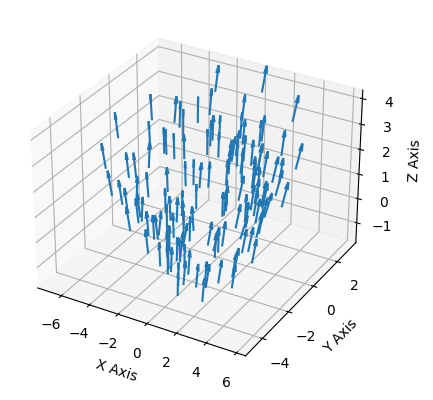

In [192]:
nonlinear = torch.nn.Sequential(
    torch.nn.Linear(256, 64, bias=True),
    torch.nn.LayerNorm(64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64, 64, bias=True),
    torch.nn.LayerNorm(64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64, FEATURE_DIM, bias=True),
)
nonlinear.load_state_dict(torch.load(SAM_PROJ_PATH))
nonlinear = nonlinear.cuda()
nonlinear.eval()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
# op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
hp = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument('--target', default='scene', const='scene', nargs='?', choices=['scene', 'seg', 'feature', 'coarse_seg_everything', 'contrastive_feature', 'xyz'])
parser.add_argument('--idx', default=0, type=int)
parser.add_argument("--configs", type=str, default = "./arguments/hypernerf/default.py")
parser.add_argument('--precomputed_mask', default=None, type=str)

args = get_combined_args(parser, MODEL_PATH)

if args.configs:
    import mmcv
    from utils.params_utils import merge_hparams
    config = mmcv.Config.fromfile(args.configs)
    args = merge_hparams(args, config)

dataset = model.extract(args)
hyperparam = hp.extract(args)
dataset.need_features = True
dataset.need_masks = True

# gaussians = GaussianModel(dataset.sh_degree, hyperparam)
gaussians = None
feature_gaussians = FeatureGaussianModel(dataset.sh_degree, FEATURE_DIM, hyperparam)
scene = Scene(dataset, gaussians, feature_gaussians, load_iteration=-1, feature_loaded_iteration=-1, target='contrastive_feature')

xyz = feature_gaussians.get_xyz
point_features = feature_gaussians.get_sam_features
# print(xyz.device)
# print(point_features.device)

## Load SAM

In [193]:
model_type = SAM_ARCH
sam = sam_model_registry[model_type](checkpoint=SAM_CKPT_PATH).to('cuda')
predictor = SamPredictor(sam)

## Begin Segmentation

In [194]:
cameras = [i for i in scene.getVideoCameras()]
print("There are",len(cameras),"views in the dataset.")

There are 539 views in the dataset.


torch.Size([3, 960, 536])


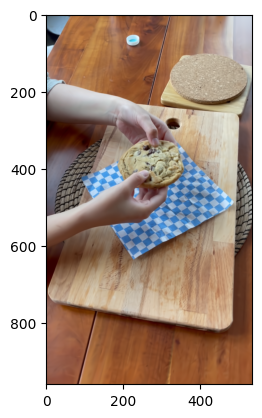

sam_features:  torch.Size([1, 256, 64, 64])


In [195]:
ref_img_camera_id = 0
mask_img_camera_id = 0

with torch.no_grad():
    view = cameras[ref_img_camera_id]
    bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    rendering = render(view, feature_gaussians, pipeline, background, cam_type="blender")["render"]
    print(rendering.shape)
    img = to8b(rendering).transpose(1,2,0)
    plt.imshow(img)
    # plt.axis('off')
    plt.show()
    # img = cv2.resize(img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8), dsize=(1024,1024), fx=1, fy=1, interpolation=cv2.INTER_LINEAR)

    predictor.set_image(img)
    sam_feature = predictor.features
    # sam_feature = view.original_features

    bg_feature = [0 for i in range(FEATURE_DIM)]
    background_feature = torch.tensor(bg_feature, dtype=torch.float32, device="cuda")

    start_time = time.time()
    rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background_feature)['render']
    time1 = time.time() - start_time
    time1 = 0

H, W = sam_feature.shape[-2:]
print("sam_features: ", sam_feature.shape)
# print("rendered_feature: ", rendered_feature.shape)

# print("time1: ", time1)

## Input Prompts

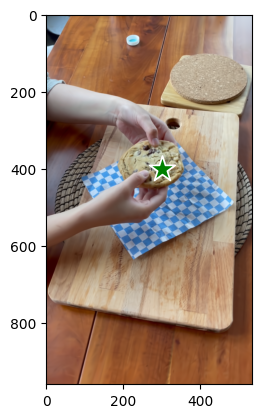

In [196]:
input_point = np.array([[300, 400]])
input_label = np.ones(len(input_point))

# plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

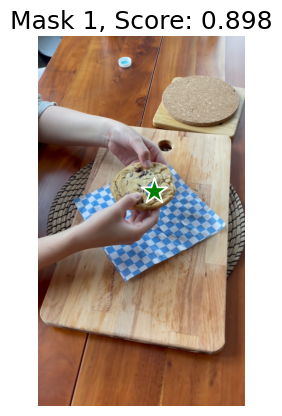

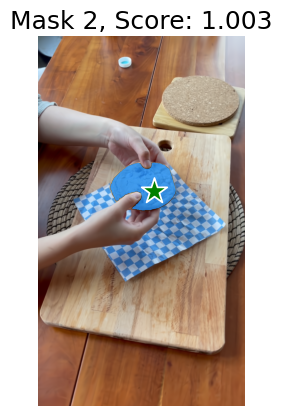

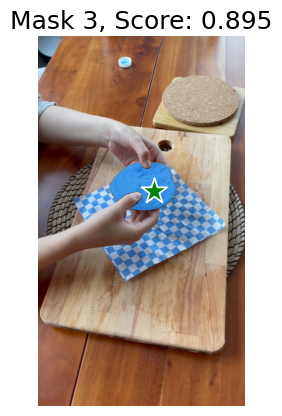

In [197]:
with torch.no_grad():
    vanilla_masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )
    
l = len(vanilla_masks)

for i, (mask, score) in enumerate(zip(vanilla_masks, scores)):
    plt.figure()
    # plt.subplot(1, l, i+1)
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [198]:
print("vanilla_masks: ", vanilla_masks.shape)
masks = torch.nn.functional.interpolate(torch.from_numpy(vanilla_masks).float().unsqueeze(0), (64,64), mode='bilinear').squeeze(0).cuda()
masks[masks > 0.5] = 1
masks[masks != 1] = 0
print("masks resized: ", masks.shape)

vanilla_masks:  (3, 960, 536)
masks resized:  torch.Size([3, 64, 64])


## Generate Average Pooled SAM Feature Query

In [199]:
# mask_id = 0
mask_id = np.argmax(scores)
origin_ref_mask = torch.tensor(vanilla_masks[mask_id]).float().cuda()

# if origin_ref_mask.shape != (64,64):
#     ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (64,64), mode='bilinear').squeeze().cuda()
#     ref_mask[ref_mask > 0.5] = 1
#     ref_mask[ref_mask != 1] = 0
# else:
#     ref_mask = origin_ref_mask
    
# sam features
start_time = time.time()

low_dim_features = nonlinear(
    sam_feature.view(-1, H*W).permute([1,0])
).squeeze().permute([1,0]).reshape([-1, H, W])

# Feature Field query
# mask_low_dim_features = ref_mask.unsqueeze(0) * low_dim_features
# mask_pooling_prototype = mask_low_dim_features.sum(dim = (1,2)) / torch.count_nonzero(ref_mask)
ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (358, 200), mode='bilinear').squeeze().cuda()
ref_mask[ref_mask > 0.5] = 1
ref_mask[ref_mask != 1] = 0
mask_low_dim_features = ref_mask.unsqueeze(0) * rendered_feature
mask_pooling_prototype = mask_low_dim_features.sum(dim = (1,2)) / torch.count_nonzero(ref_mask)

time2 = time.time() - start_time
print("time2: ", time2)


time2:  0.00121307373046875


In [200]:
import kmeans_pytorch
import importlib
importlib.reload(kmeans_pytorch)
from kmeans_pytorch import kmeans

# K-means or not

start_time = time.time()

bg_color = [0 for i in range(32)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background)['render']

# similarity = torch.cosine_similarity(mask_pooling_prototype.cuda(), rendered_feature.permute([1, 2, 0]), dim=-1)

temp_mask = torch.einsum('C,CHW->HW', mask_pooling_prototype.cuda(), rendered_feature)
temp_mask = torch.nn.functional.interpolate(similarity.float().unsqueeze(0).unsqueeze(0), (64,64), mode='bilinear').squeeze().cuda()
temp_mask[temp_mask > 0] = 1
temp_mask[temp_mask != 1] = 0


ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (64, 64), mode='bilinear').squeeze().cuda()
ref_mask[ref_mask > 0.5] = 1
ref_mask[ref_mask != 1] = 0
iob = (temp_mask * ref_mask).sum(dim = (-1, -2)) / ref_mask.sum()
print(iob.item())

if iob > 0.9:
    fmask_prototype = mask_pooling_prototype.unsqueeze(0)
else:
    # fmask_prototype = mask_pooling_prototype.unsqueeze(0)
    downsampled_masks = torch.nn.functional.adaptive_avg_pool2d(ref_mask.unsqueeze(0).unsqueeze(0), (8,8)).squeeze()
    downsampled_features = torch.nn.functional.adaptive_avg_pool2d(mask_low_dim_features.unsqueeze(0), (8,8)).squeeze(0)
    downsampled_features /= downsampled_masks.unsqueeze(0)

    downsampled_masks[downsampled_masks != 0]= 1
    init_prototypes = downsampled_features[:, downsampled_masks.bool()].permute([1,0])


    masked_sam_features = low_dim_features[:, ref_mask.bool()]
    masked_sam_features = masked_sam_features.permute([1,0])
    
    num_clusters = init_prototypes.shape[0]
    print(num_clusters)
    
    if num_clusters <= 1:
        num_clusters = min(int(masked_sam_features.shape[0] ** 0.5), 32)
        init_prototypes = []

    cluster_ids_x, cluster_centers = kmeans(
        X=masked_sam_features, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda')
    )

    temp_mask = torch.sigmoid(torch.einsum('NC,CHW->NHW', cluster_centers.cuda(), rendered_feature))
    temp_mask = torch.nn.functional.interpolate(temp_mask.float().unsqueeze(1), (64,64), mode='bilinear').squeeze().cuda()
    temp_mask[temp_mask >= 0.5] = 1
    temp_mask[temp_mask != 1] = 0
    temp_mask = temp_mask.squeeze()

    ioa = (temp_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / (temp_mask.sum(dim = (-1, -2)) + 1e-5)
    iob = (temp_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / ref_mask.sum()
    ioa = ioa.squeeze()
    iob = iob.squeeze()
    cluster_mask = ioa > 0.75

    # NMS
    for i in range(len(cluster_mask)):
        if not cluster_mask[i]:
            continue

        for j in range(i+1, len(cluster_mask)):
            if not cluster_mask[j]:
                continue

            if (temp_mask[j] * temp_mask[i]).sum() / ((temp_mask[j] + temp_mask[i]).sum() - (temp_mask[j] * temp_mask[i]).sum()) > 0.75:
                if ioa[i] > ioa[j]:
                    cluster_mask[j] = False
                else:
                    cluster_mask[i] = False
                    break
    
    cluster_centers = cluster_centers.cuda()
    cluster_centers = cluster_centers[cluster_mask, :]
    fmask_prototype = torch.cat([mask_pooling_prototype.unsqueeze(0), cluster_centers.cuda()], dim = 0)
    
time3 = time.time() - start_time
print(time3)

0.982758641242981


In [201]:
mask_prototype = fmask_prototype

start_time = time.time()
if mask_prototype.shape[0] == 1 or len(mask_prototype.shape) == 1:
    print("Using masked average pooling feature as the query")
    point_logits = torch.einsum('NC,C->N', point_features, mask_prototype.squeeze())
    point_scores = torch.sigmoid(point_logits)
else:
    print("Using K-Means features as queries")
    point_logits = torch.einsum('NC,LC->NL', point_features, mask_prototype)
    point_logits = point_logits.max(-1)[0]
    point_scores = torch.sigmoid(point_logits)
    
two_d_point_logits = torch.einsum('NC,CHW->NHW', mask_prototype.cuda(), rendered_feature).max(dim = 0)[0]
two_d_point_logits = torch.nn.functional.interpolate(two_d_point_logits.float()[None, None, ...], ref_mask.shape[-2:], mode='bilinear').squeeze().cuda()
in_mask_logits = two_d_point_logits[ref_mask.bool()]

# Adjustable Threshold
thresh = max(max(in_mask_logits.mean() + in_mask_logits.std(), torch.topk(point_logits, int(point_logits.shape[0]*0.1))[0][-1]), 0)
# thresh = in_mask_logits.mean() - in_mask_logits.std()

mask = point_logits > thresh
os.makedirs(os.path.join('./segmentation_res/'), exist_ok=True)
torch.save(mask, './segmentation_res/test_mask.pt')
print("Total Gaussians Number: ", feature_gaussians.get_xyz.shape[0])
print("Segmented Gaussians NUmber: ", torch.count_nonzero(mask).item())
time4 = time.time() - start_time
print(time4)

Using masked average pooling feature as the query
Total Gaussians Number:  141954
Segmented Gaussians NUmber:  878
0.008974790573120117


## Post-Process

In [202]:
opacity = feature_gaussians._opacity
shs = feature_gaussians.get_features
means3D = feature_gaussians.get_xyz
scales = feature_gaussians._scaling
rotations = feature_gaussians._rotation
ts = torch.tensor(view.time).to(means3D.device).repeat(means3D.shape[0],1)

means3D_final, scales_final, rotations_final, opacity_final, shs_final = feature_gaussians._deformation(means3D, scales, 
                                                                 rotations, opacity, shs,
                                                                 ts)

In [203]:
start_time = time.time()
selected_xyz = means3D_final[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
# write_ply('./segmentation_res/vanilla_seg.ply', selected_xyz)

selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=1)
filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask_.clone(), feature_gaussians=feature_gaussians, view=view, sam_mask=ref_mask.clone(), pipeline_args=pipeline.extract(args))
# filtered_points, thresh = postprocess_statistical_filtering(pcd=selected_xyz.clone(), max_time=3)

# print(thresh)
# write_ply('./segmentation_res/filtered_seg.ply', filtered_points)
time5 = time.time() - start_time
print(time5)
print(len(filtered_points))

tensor(7.6433, device='cuda:0') std_nearest_k_distance
tensor(0.2610, device='cuda:0') std_nearest_k_distance
tensor(0.1498, device='cuda:0') std_nearest_k_distance
tensor(0.0896, device='cuda:0') std_nearest_k_distance
test threshold tensor(0.1181, device='cuda:0')
0.04080009460449219
844


In [188]:
start_time = time.time()
final_xyz, point_mask, final_normals = postprocess_growing(means3D_final, None, torch.from_numpy(filtered_points).cuda(), None, max(thresh, 0.05), grow_iter = 1)

time6 = time.time() - start_time
print(time6)
print(point_mask.count_nonzero())
torch.save(torch.logical_and(feature_gaussians.get_opacity.squeeze() > 0.1, point_mask.bool()), './segmentation_res/pre_final_mask.pt')

0.0029594898223876953
tensor(24092, device='cuda:0')


## Render Segmentation Result

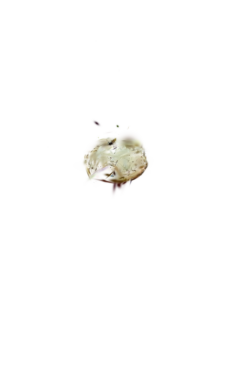

In [204]:
bg_color = [1 for i in range(3)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

seg = render_segmentation(cameras[0], feature_gaussians, pipeline, background, mask)["render"]

img_seg = to8b(seg.detach()).transpose(1,2,0)
plt.imshow(img_seg)
plt.axis('off')
plt.show()

In [17]:
render_images = []
for idx, view in enumerate(tqdm(cameras, desc="Rendering progress")):
    rendering = render_segmentation(view, feature_gaussians, pipeline, background, mask)["render"]
    render_images.append(to8b(rendering.detach()).transpose(1,2,0))
    # render_list.append(rendering)
    
imageio.mimwrite(os.path.join(MODEL_PATH, 'video', "ours_{}".format(FEATURE_GAUSSIAN_ITERATION), 'video_seg.mp4'), render_images, fps=30)

Rendering progress:   9%|▊         | 47/539 [00:00<00:03, 150.84it/s]

Rendering progress: 100%|██████████| 539/539 [00:03<00:00, 151.07it/s]
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (536, 960) to (544, 960) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x5a97b40] Warning: data is not aligned! This can lead to a speed loss
